In [ ]:
!pip install Kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json API key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d viktormodroczky/facial-affect-dataset
!unzip facial-affect-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_balanced_3x/train/surprise/aug_822272image0027538.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822277image0025371.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822289ffhq_508.png  
  inflating: data_balanced_3x/train/surprise/aug_822300ffhq_150.png  
  inflating: data_balanced_3x/train/surprise/aug_822334image0034512.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822428image0028307.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822509image0027785.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822688image0030982.jpg  
  inflating: data_balanced_3x/train/surprise/aug_822844image0034611.jpg  
  inflating: data_balanced_3x/train/surprise/aug_82329image0006890.jpg  
  inflating: data_balanced_3x/train/surprise/aug_823418image0033832.jpg  
  inflating: data_balanced_3x/train/surprise/aug_823471ffhq_464.png  
  inflating: data_balanced_3x/train/surprise/aug_8234image0016697.jpg  
  

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Directory paths
train_dir = "/content/data_balanced_3x/train"
val_dir = "/content/data_balanced_3x/test"  # Assuming test_dir also works as validation

# Supported image formats
valid_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')

# Verify images in each class folder
selected_classes = ['sad', 'happy', 'neutral', 'anger']
for class_name in selected_classes:
    train_class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)
    train_images = [f for f in os.listdir(train_class_path) if f.lower().endswith(valid_formats)]
    val_images = [f for f in os.listdir(val_class_path) if f.lower().endswith(valid_formats)]
    print(f"{class_name} - Training images: {len(train_images)}, Validation images: {len(val_images)}")

# Set image size and batch size
img_height, img_width = 96, 96
batch_size = 32

sad - Training images: 12303, Validation images: 3075
happy - Training images: 12303, Validation images: 3075
neutral - Training images: 12303, Validation images: 3075
anger - Training images: 12303, Validation images: 3075


In [ ]:
# ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow from directory for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,
    shuffle=False,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,
    shuffle=False,
    seed=42
)

Found 49212 images belonging to 4 classes.
Found 12300 images belonging to 4 classes.


In [ ]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(4, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# # Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,658,052 (13.95 MB)

 Trainable params: 3,657,156 (13.95 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1538/1538 ━━━━━━━━━━━━━━━━━━━━ 197s 117ms/step - accuracy: 0.2767 - loss: 5.1531 - val_accuracy: 0.3318 - val_loss: 1.9635 - learning_rate: 0.0010
Epoch 2/50
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 167s 108ms/step - accuracy: 0.4044 - loss: 1.6553 - val_accuracy: 0.4874 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 3/50
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 171s 111ms/step - accuracy: 0.5193 - loss: 1.0531 - val_accuracy: 0.5354 - val_loss: 1.2847 - learning_rate: 0.0010
Epoch 4/50
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 197s 108ms/step - accuracy: 0.5779 - loss: 1.1416 - val_accuracy: 0.5893 - val_loss: 1.2548 - learning_rate: 0.0010
Epoch 5/50
1537/1538 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6104 - loss: 1.1459
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 218s 118ms/step - accuracy: 0.6104 - loss: 1.1459 - val_accuracy: 0.5667 - val_loss: 1.2403 - learning_rate: 0.0010
Epoch 6/50
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 187s 109ms/step - accura

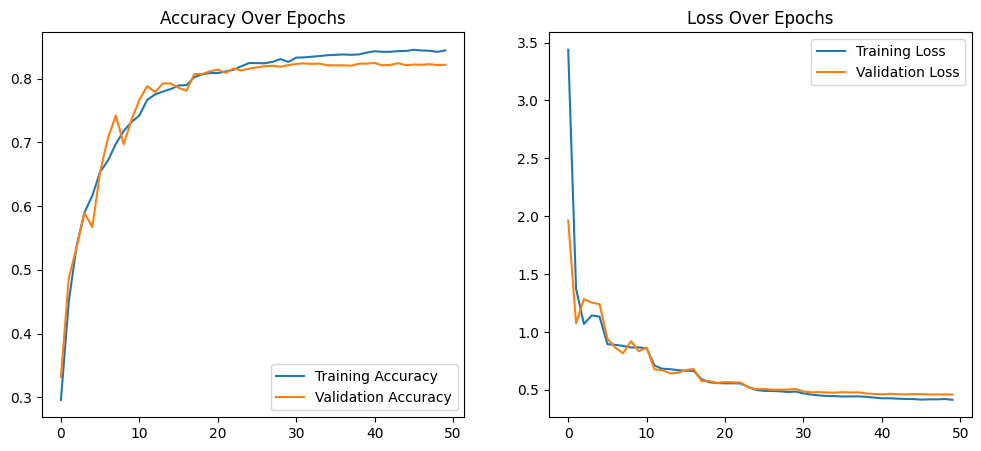

In [ ]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

385/385 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


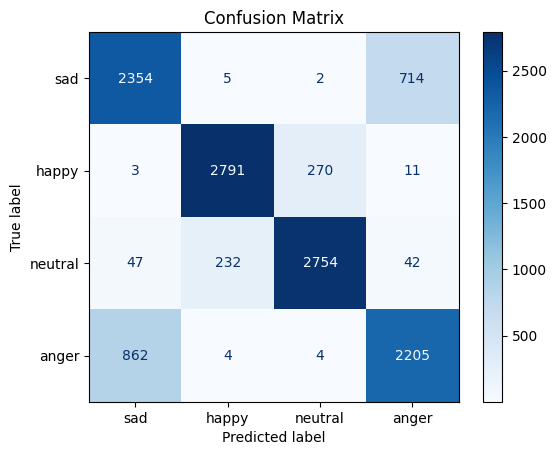

Classification Report:
              precision    recall  f1-score   support

         sad       0.72      0.77      0.74      3075
       happy       0.92      0.91      0.91      3075
     neutral       0.91      0.90      0.90      3075
       anger       0.74      0.72      0.73      3075

    accuracy                           0.82     12300
   macro avg       0.82      0.82      0.82     12300
weighted avg       0.82      0.82      0.82     12300



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the validation set
val_preds = model.predict(val_generator)  # Predictions from the model on validation data
val_preds_classes = np.argmax(val_preds, axis=1)  # Convert predicted probabilities to class labels
val_true_classes = val_generator.classes  # True class labels from the generator

# Compute and display the Confusion Matrix
cm = confusion_matrix(val_true_classes, val_preds_classes, labels=range(len(selected_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=selected_classes))


In [ ]:
# Save the trained model
model.save('/content/farhanemotion20epoches.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("farhanemotion20epoches.h5")
# Or for the SavedModel format
# model = load_model("emotion_detection_model")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the directory path for the test images
test_dir = "/content/data_balanced_3x/test"

# Define only the classes you want to test
selected_classes = ['sad', 'happy', 'neutral', 'anger']

# Set the image size and batch size
img_height, img_width = 96, 96
batch_size = 32

# Preprocess the images
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create a generator for the test images with only the specified classes
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,  # Include only the selected classes
    shuffle=False
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


Found 12300 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/385 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8277 - loss: 0.5923
Test Accuracy: 0.79
Test Loss: 0.60


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Set the image path
image_path = "/content/data_balanced_3x/test/happy/aug_102125ffhq_4485.png"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale the image

# Predict the class
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Map class indices to class labels
class_labels = ['sad', 'happy', 'neutral', 'anger']
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")
print(f"Prediction confidence: {prediction[0][predicted_class_index]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
Predicted class: happy
Prediction confidence: 0.99


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Set the image path
image_path = "/content/data_balanced_3x/test/neutral/aug_105603ffhq_4405.png"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale the image

# Predict the class
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Map class indices to class labels
class_labels = ['sad', 'happy', 'neutral', 'anger']
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")
print(f"Prediction confidence: {prediction[0][predicted_class_index]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: neutral
Prediction confidence: 0.98


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

# Step 1: Manually upload your image
uploaded = files.upload()  # Use this to upload the file manually

# Step 2: Get the filename of the uploaded image
image_path = list(uploaded.keys())[0]  # This will automatically get the file name

# Step 3: Preprocess the image for model prediction
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Step 4: Predict the class of the image
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Map class indices to class labels
class_labels = ['sad', 'happy', 'neutral', 'anger']
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")
print(f"Prediction confidence: {prediction[0][predicted_class_index]:.2f}")


Saving aug_387719image0011609.jpg to aug_387719image0011609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: sad
Prediction confidence: 0.58
